In [1]:
import os
from softce_validation import utils
from softce_validation.tasks.available_tasks import get_available_tasks
import seaborn as sns
import pandas as pd
import jax.numpy as jnp
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import ArrayLike
import matplotlib.pyplot as plt

os.chdir(utils.get_abspath_project_root())

plt.style.use('./plots/style.mplstyle')
palette = {
    "True": "#00B945",
    "SoftCE": "#E59019",
    "ELBO": "#115c9f",
}

In [2]:
task_samples = {
    task: dict(jnp.load(f"results/samples/{task}.npz", allow_pickle=True))
    for task in get_available_tasks().keys()
}

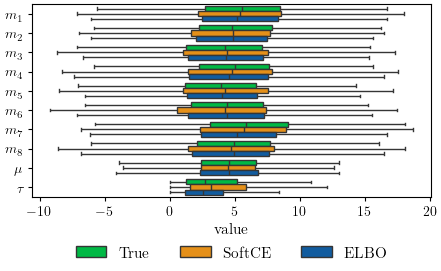

In [3]:
# eight schools
def samples_to_df(samples):
    dfs = []
    for k, samps in samples.items():
        columns = {}
        for name, arr in samps.item().items():
            if arr.ndim == 1:
                columns[name] = arr
            
            if arr.ndim == 2:
                for i in range(arr.shape[-1]):
                    columns[f"{name}[{i}]"] = arr[:, i]
        df = pd.DataFrame(columns)
        df["source"] = k
        dfs.append(df)

    df = pd.concat(dfs)
    return df.melt(id_vars="source", var_name="parameter", value_name="parameter_value")

samples = task_samples["eight_schools"]
df = samples_to_df(samples)

# Rename parameters to match paper:
rename_dict = {f"theta[{i}]": rf"$m_{{{i+1}}}$" for i in range(8)}
rename_dict["mu"] = r"$\mu$"
rename_dict["tau"] = r"$\tau$"
df["parameter"] = df["parameter"].replace(rename_dict)

plt.figure(figsize=(5.15,2.5))
sns.boxplot(
    data=df,
    x="parameter_value",
    y="parameter",
    hue="source",
    showfliers="",
    palette=palette,
    saturation=1,
    )

plt.legend(bbox_to_anchor=(0.5, -0.4), loc="lower center", ncol=3)
plt.xlabel("value")
plt.ylabel(None)
plt.savefig("plots/single_run_eight_schools.pdf")

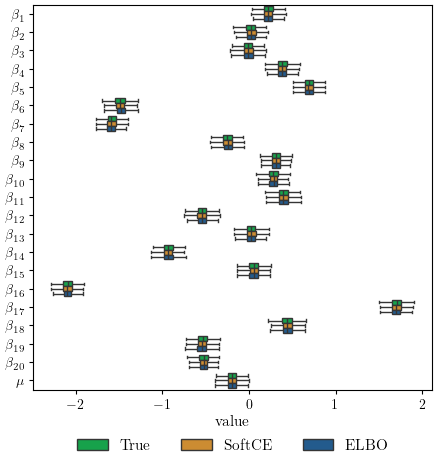

In [4]:
# Linear regression
samples = task_samples["linear_regression"]
df = samples_to_df(samples)

# Rename parameters to match paper:
rename_dict = {f"beta[{i}]": rf"$\beta_{{{i+1}}}$" for i in range(20)}
rename_dict["bias"] = r"$\mu$"
df["parameter"] = df["parameter"].replace(rename_dict)

plt.figure(figsize=(5.15,5))
sns.boxplot(
    data=df,
    x="parameter_value",
    y="parameter",
    hue="source",
    showfliers="",
    palette=palette,
    )
plt.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center", ncol=3)
plt.xlabel("value")
plt.ylabel(None)
plt.savefig("plots/single_run_linear_regression.pdf")


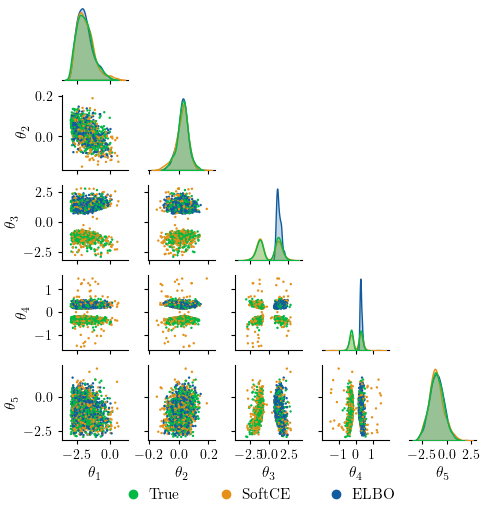

<Figure size 500x400 with 0 Axes>

In [5]:
samples = task_samples["slcp"]
samples = {k: v.item()["theta"] for k, v in samples.items()}

def _filter_outliers(data, n):
    q1 = jnp.nanpercentile(data, 25, axis=0)
    q3 = jnp.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - n * iqr
    upper_bound = q3 + n * iqr
    mask = jnp.logical_and(data >= lower_bound, data <= upper_bound).all(axis=1)
    return data[mask]

def pairplot_dictionary(
    data: dict[str, ArrayLike],
    *,
    column_names: list[str] | None = None,
    filter_outliers: int | float = 3,
    shuffle: bool = True,
    s: int | float = 3,
):
    """Generate a poirplot from a dictionary of arrays."""
    if max(arr.ndim for arr in data.values()) > 2:
        raise ValueError("Arrays must be at most 2 dimensional.")
    data_2d = {
        k: np.random.permutation(arr)
        for k, arr in data.items()
        if arr.ndim == 2
    }
    dfs = []

    if column_names is None:
        column_names = range(list(data_2d.values())[0].shape[1])

    for k, arr in data_2d.items():
        arr = _filter_outliers(arr, filter_outliers)
        df_i = pd.DataFrame(arr, columns=column_names)
        df_i["source"] = k
        dfs.append(df_i)

    df = pd.concat(dfs)

    if shuffle:
        df = df.sample(frac=1)

    df = df.reset_index(drop=True)

    pairplot = sns.pairplot(
        df,
        hue="source",
        plot_kws={"s": s, "rasterized": True, "edgecolor": "none"},
        diag_kws={"common_norm": False},
        corner=True,
        hue_order=data.keys(),
        height=1,
        palette=palette,
    )
    pairplot._legend.remove()  # Point size too small
    return pairplot

g = pairplot_dictionary(
    samples,
    s=3,
    filter_outliers=2.,
    column_names=[fr"$\theta_{i+1}$" for i in range(5)],
    )

handles = [
    mlines.Line2D(
        [],
        [],
        color=v,
        label=k,
        marker='o',
        linestyle="None",
        )
    for k, v in palette.items()]

plt.legend(
    handles=handles,
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(-2.3, -1),
    handletextpad=0.05,
    )
plt.figure(figsize=(5,4))
g.savefig("plots/single_run_slcp.pdf", dpi=300)

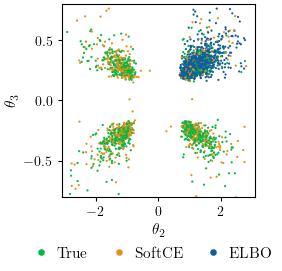

In [7]:
# Plot focussing on the pairwise marginal showing the four modes

df = []

for method, samps in samples.items():
    df.append(
        pd.DataFrame({
            r"$\theta_2$": samps[:, 2],
            r"$\theta_3$": samps[:, 3],
            "method": method,
        }),
    )
df = pd.concat(df)
df = df.sample(frac=1, random_state=1)

sns.scatterplot(
    df,
    x=r"$\theta_2$",
    y=r"$\theta_3$",
    hue="method",
    palette=palette,
    edgecolor="none",
    s=2.5,
    hue_order=palette.keys(),
    rasterized=True,
    )

plt.xlim(-3.1, 3.1)
plt.ylim(-0.8, 0.8)
fig = plt.gcf()
fig.set_size_inches(2.5, 2.5)

plt.legend(
    ncol=3,
    loc="lower center",
    bbox_to_anchor=(0.45, -0.4),
    handletextpad=0.05,
    markerscale=3,
    columnspacing=1,
)
fig.savefig("plots/slcp_mass_covering.pdf", dpi=300)
